In [1]:
%pylab inline
from pylab import *

import itertools
import mpl_toolkits.mplot3d
import os
import scipy.io

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../../lib")

import flashlight.curve_utils         as curve_utils
import flashlight.spline_utils        as spline_utils
import flashlight.quadrotor_camera_3d as quadrotor_camera_3d

# ignore "Polyfit may be poorly conditioned" warnings, which occur when computing
# control trajectories with very small timesteps
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("../data/01"):  os.makedirs("../data/01")
if not os.path.exists("../plots/01"): os.makedirs("../plots/01")

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_camera_3d: Constructing sympy symbols...
flashlight.quadrotor_camera_3d: Finished constructing sympy symbols (0.011 seconds).
flashlight.quadrotor_camera_3d: Loading sympy modules...
flashlight.quadrotor_camera_3d: Finished loading sympy modules (0.005 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


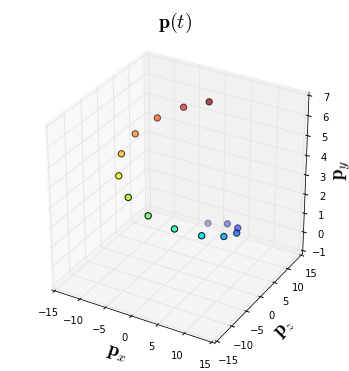

In [2]:
t_begin       = 0.0
t_end         = 2.0*pi
num_timesteps = 1000
t             = linspace(t_begin,t_end,num_timesteps)
dt            = (t_end-t_begin) / (num_timesteps-1)

p_look_at       = c_[ zeros_like(t), zeros_like(t), zeros_like(t) ]
y_axis_cam_hint = c_[ zeros_like(t), ones_like(t),  zeros_like(t) ]

num_timesteps_sparse = 15
t_sparse             = linspace(t_begin,t_end,num_timesteps_sparse)

p_x = 10*cos(t_sparse)
p_y = t_sparse
p_z = 10*sin(t_sparse)
P   = c_[ p_z, p_y, p_x ]

scipy.io.savemat("../data/01/t_sparse.mat", {"t_sparse":t_sparse}, oned_as="column")

figsize(6,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(P[:,0], P[:,2], P[:,1], c=t_sparse, cmap="jet", marker="o", s=40);
title("$\\mathbf{p}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

In [3]:
degrees     = [5,7,9]
derivatives = [1,2,3,4,5]
lambs       = [ [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1] ]
U           = {}

num_degrees     = len(degrees)
num_derivatives = len(derivatives)

for i,j in itertools.product(range(num_degrees),range(num_derivatives)):

    degree     = degrees[i]
    derivative = derivatives[j]
    lamb       = lambs[j]
    
    C,T,sd           = spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(P,degree=degree,lamb=lamb)
    P_eval,T_eval,dT = spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(C,T,sd,num_samples=num_timesteps)
    s                = linspace(0,1,num_timesteps)

    P_eval_s, t_s, P_eval_s_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s)

    p_body          = P_eval_s
    q_qdot_qdotdot  = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_body, p_look_at, y_axis_cam_hint, dt)
    u               = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot, atol=1e-7)

    u_name = "u_mv_%d_d%d" % (degree,derivative)

    U[u_name] = u
    
scipy.io.savemat("../data/01/U.mat", U)

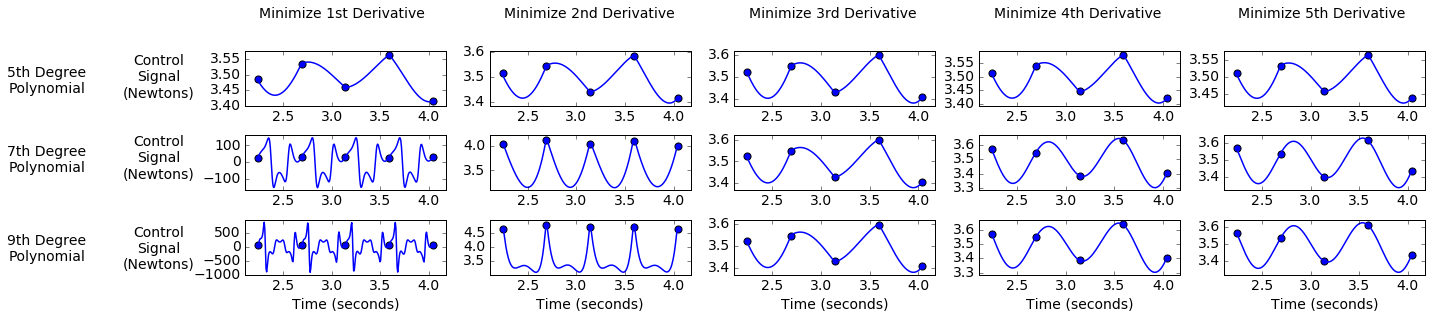

In [4]:
t_sparse_ind = clip(floor(t_sparse/dt).astype(int32),0,num_timesteps-1)

k = 357
kk = 5
ui = 0
lw = 1.5
ms = 50

fig = plt.figure(figsize=(20,4.5))

matplotlib.rcParams.update({'font.size': 14})

subplot(3,5,1);  plot(t[k:-k], U["u_mv_5_d1"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_5_d1"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,2);  plot(t[k:-k], U["u_mv_5_d2"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_5_d2"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,3);  plot(t[k:-k], U["u_mv_5_d3"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_5_d3"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,4);  plot(t[k:-k], U["u_mv_5_d4"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_5_d4"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,5);  plot(t[k:-k], U["u_mv_5_d5"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_5_d5"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);

subplot(3,5,6);  plot(t[k:-k], U["u_mv_7_d1"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_7_d1"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,7);  plot(t[k:-k], U["u_mv_7_d2"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_7_d2"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,8);  plot(t[k:-k], U["u_mv_7_d3"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_7_d3"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,9);  plot(t[k:-k], U["u_mv_7_d4"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_7_d4"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);
subplot(3,5,10); plot(t[k:-k], U["u_mv_7_d5"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_7_d5"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5);

subplot(3,5,11); plot(t[k:-k], U["u_mv_9_d1"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_9_d1"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5); xlabel("Time (seconds)");
subplot(3,5,12); plot(t[k:-k], U["u_mv_9_d2"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_9_d2"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5); xlabel("Time (seconds)");
subplot(3,5,13); plot(t[k:-k], U["u_mv_9_d3"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_9_d3"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5); xlabel("Time (seconds)");
subplot(3,5,14); plot(t[k:-k], U["u_mv_9_d4"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_9_d4"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5); xlabel("Time (seconds)");
subplot(3,5,15); plot(t[k:-k], U["u_mv_9_d5"][k:-k,ui], linewidth=lw); scatter(t_sparse[kk:-kk],U["u_mv_9_d5"][t_sparse_ind[kk:-kk],ui],s=ms); gca().locator_params(tight=True, nbins=5); xlabel("Time (seconds)");

fig.tight_layout()

fig.subplots_adjust(left=0.17,top=0.85)

figtext(.005, 0.720, "5th Degree\nPolynomial", multialignment="center");
figtext(.005, 0.475, "7th Degree\nPolynomial", multialignment="center");
figtext(.005, 0.200, "9th Degree\nPolynomial", multialignment="center");

figtext(0.085, 0.705, "Control\nSignal\n(Newtons)", multialignment="center");
figtext(0.085, 0.455, "Control\nSignal\n(Newtons)", multialignment="center");
figtext(0.085, 0.175, "Control\nSignal\n(Newtons)", multialignment="center");

figtext(.18, 0.95, "Minimize 1st Derivative", multialignment="center");
figtext(.35, 0.95, "Minimize 2nd Derivative", multialignment="center");
figtext(.52, 0.95, "Minimize 3rd Derivative", multialignment="center");
figtext(.69, 0.95, "Minimize 4th Derivative", multialignment="center");
figtext(.86, 0.95, "Minimize 5th Derivative", multialignment="center");

savefig("../plots/01/evaluating_different_spline_degrees_and_derivatives.pdf");